<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Ресемплирование" data-toc-modified-id="Ресемплирование-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-на-статичность" data-toc-modified-id="Проверка-на-статичность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка на статичность</a></span></li><li><span><a href="#Скользящая-средняя" data-toc-modified-id="Скользящая-средняя-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящая средняя</a></span></li><li><span><a href="#Тренд,-Сезонность,-Остаток" data-toc-modified-id="Тренд,-Сезонность,-Остаток-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тренд, Сезонность, Остаток</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Catboost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# базовые библиотека
import pandas as pd
import numpy as np
from timeit import default_timer as timer
import random
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# тренд, сезонность
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# кодирование и масштабирование
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit

# цвет текста
from IPython.core.display import display, HTML

#Модели обучения
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
    
data.sort_index(inplace=True)

In [3]:
def data_info(data):
    display(HTML(f'<font color="red"> Общая информация о датасете </font>'))
    display(data.info())
    
    display(HTML(f'<font color="red"> Описание данных </font>'))
    display(data.describe())
    
    display(HTML(f'<font color="red"> Описание категориальных данных </font>'))
    #display(data.describe(include=[object]))
    
    display(HTML(f'<font color="red"> Пропущенные значения признаков </font>'))
    nan_values_data = data.isna().sum().sort_values(ascending=False)
    display(nan_values_data.loc[nan_values_data > 0])
    
    display(HTML(f'<font color="red"> Heatmap пропущенных значений </font>'))
    plt.figure(figsize=(20, 20))
    sns.heatmap(data.isnull(), cmap=sns.color_palette('viridis', as_cmap=True))
    plt.show()
    
    
    display(HTML('<font color="red"> Если удалить все строки с пропущенными значениями получим <font color="blue">{:.0%}</font> потерянных данных </font>'
             .format(1 - (data.dropna(axis=0).shape[0] / data.shape[0]))))
    
    if (100 - (data.dropna(axis=0).shape[0] / data.shape[0]) * 100) > 10:
        display(HTML(f'<font color="red"> Данные <font color="blue">НУЖДАЮТСЯ</font> в предобработке </font>'))
        
    else:
        display(HTML(f'<font color="red"> Данные <font color="blue">НЕ НУЖДАЮТСЯ</font> в предобработке </font>'))
        
    
    # Correlation Heatmap числовых признаков
    numeric_columns = data.select_dtypes(exclude='object').copy(deep=True)
    plt.figure(figsize=(10, 10), dpi=80)
    heatmap = sns.heatmap(numeric_columns.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG',
                      fmt='.2g')
    heatmap.set_title('Correlation Heatmap числовых признаков',fontdict={'fontsize':20}, pad=12)
    plt.show()
    
    #Таблица уникальных значений
    display(HTML(f'<font color="red"> Количество уникальных значений </font>'))
    uniq_dict = {}
    for column in data.columns:
    
        uniq_dict[column] = len(data[column].unique())
    
    display(pd.DataFrame(data=uniq_dict, index=['Unique count']))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Series([], dtype: int64)

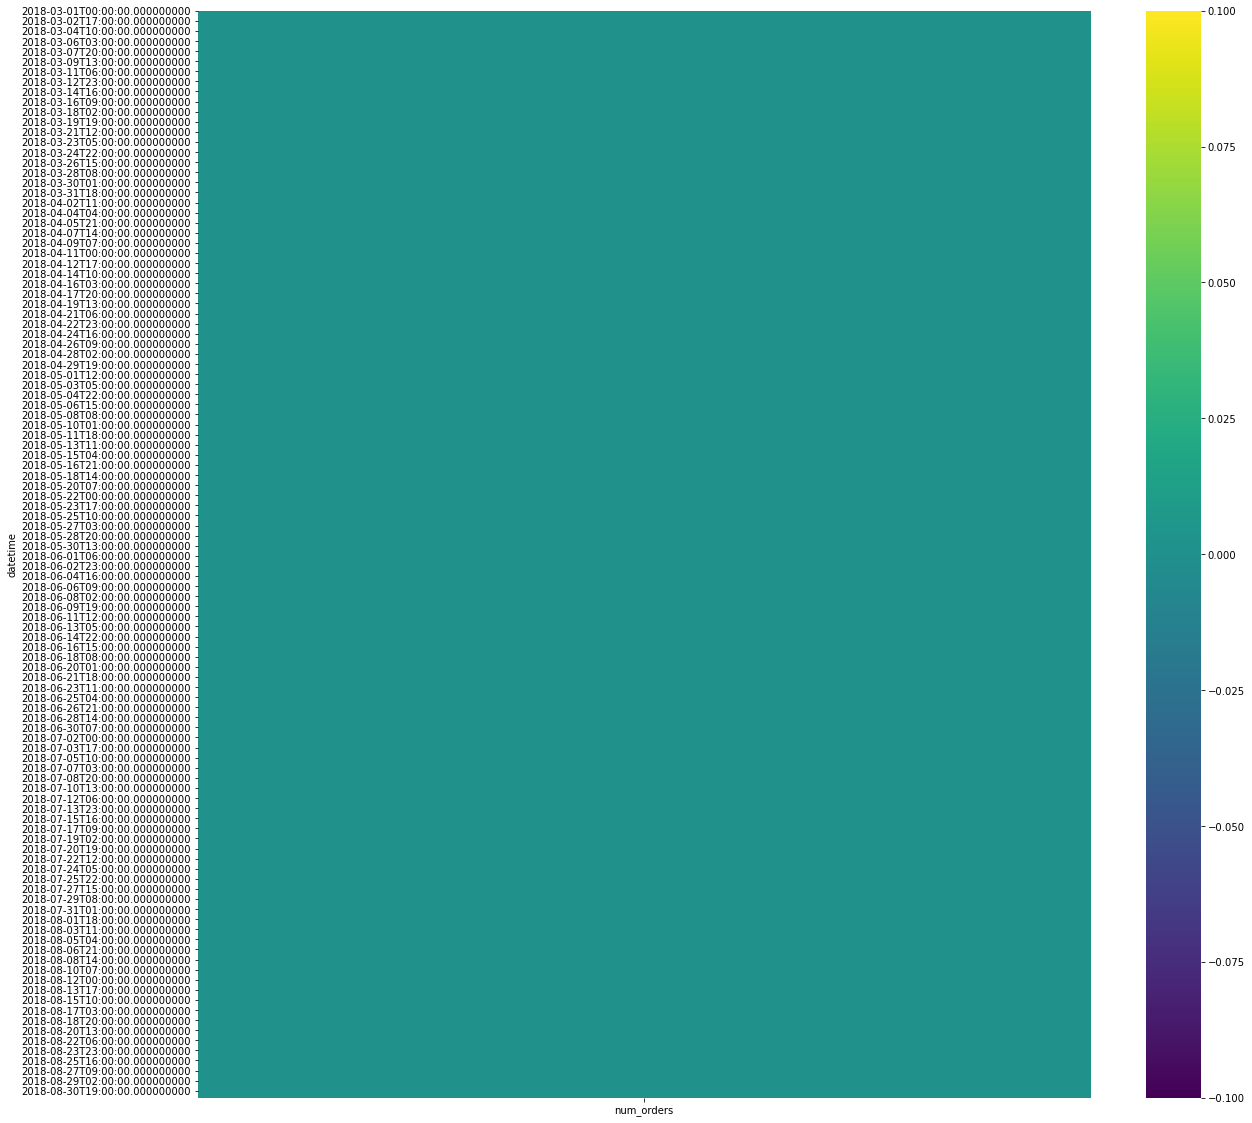

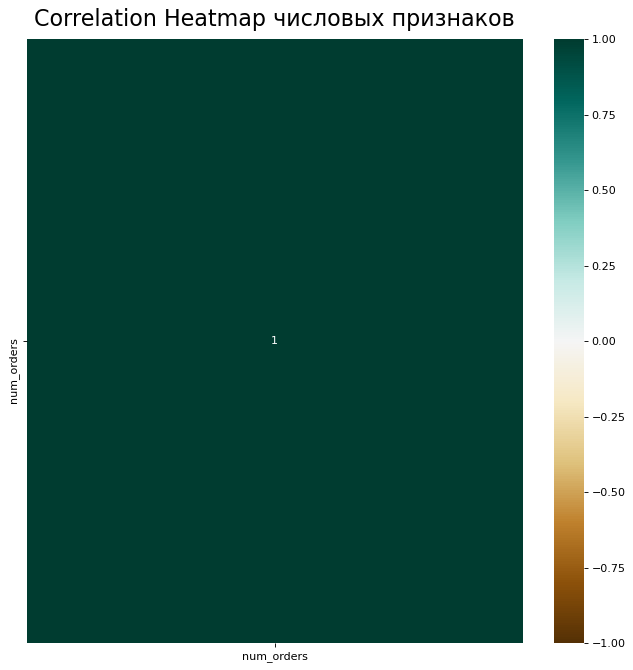

,num_orders
Unique count,81


In [4]:
data_info(data)

<AxesSubplot:xlabel='datetime'>

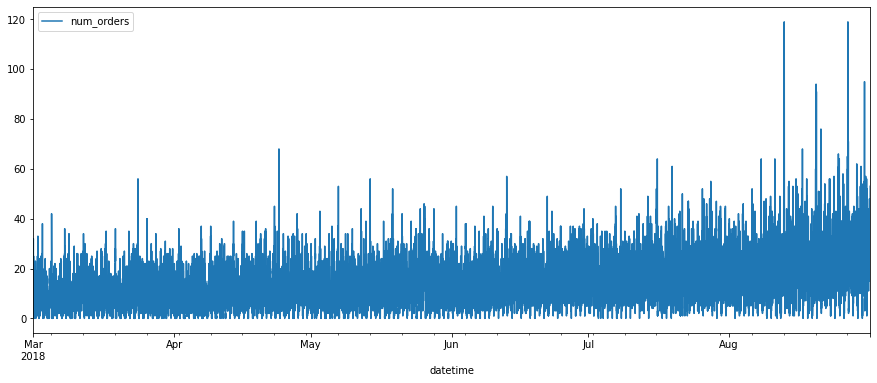

In [5]:
data.plot(figsize=(15,6))

### Ресемплирование

Исходя из задачи необходимый шаг прогнозирования определяем в 1 час.

In [6]:
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

### Проверка на статичность

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


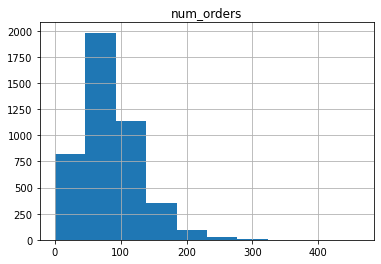

In [7]:
descr = data.describe()
data.hist()
descr

У нас достаточно однородный график гистограммы. Проверим это при помощи коэффициента вариации.

In [8]:
print(f'Коэффициент вариации V: {descr.loc["std"][0]/descr.loc["mean"][0]}')

Коэффициент вариации V: 0.5333140296285983


Проведем `тест Харки — Бера` для определения номарльности распределения, чтобы проверить предположение об однородности.

In [9]:
row =  ['JB', 'p-value', 'skew', 'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(data)

display(pd.DataFrame(data=np.column_stack(jb_test), columns=row))

,JB,p-value,skew,kurtosis
0,3644.433552,0.0,1.188552,6.762457


**p-value = 0**, значит вероятность того что гипотеза о нормально распределении отвергается с вероятностью 0%, значит наша выборка имеет нормальное распределение 

Для того чтобы убедиться в том какого типа наш ряд (стационный или нестационный) проведеём обобщенный `тест Дикки-Фуллера`. на наличие единичных корней

In [10]:
def adfuller_test(data): 
    adfuller_test = adfuller(data)
    print('adf: ', adfuller_test[0] )
    print('p-value: ', adfuller_test[1])
    print('Critical values: ', adfuller_test[4])
    if adfuller_test[0]> adfuller_test[4]['5%']: 
        print('есть единичные корни, ряд не стационарен')
    else:
        print('единичных корней нет, ряд стационарен')

In [11]:
adfuller_test(data)

adf:  -3.0689242890279558
p-value:  0.028940051402612906
Critical values:  {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
единичных корней нет, ряд стационарен


Проведенный тест `подтвердил` предположения о стационарности ряда

### Скользящая средняя

<AxesSubplot:xlabel='datetime'>

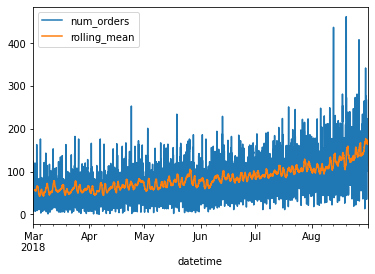

In [12]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()
data.plot()

### Тренд, Сезонность, Остаток

In [13]:
def decompose(data):
    decomposed = seasonal_decompose(data)

    plt.figure(figsize=(6, 8))
    plt.subplot(311)
    # тренд
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(312)
    decomposed.seasonal.plot(ax=plt.gca()) 
    # сезонность 
    plt.title('Seasonality')
    plt.subplot(313)
    decomposed.resid.plot(ax=plt.gca()) 
    # остаток
    plt.title('Residuals')
    plt.tight_layout()
    plt.show()
    
    # График частной автокорреляционной функции для оценки количества лагов
    plot_pacf(data, alpha=None, lags=25).set_size_inches(15, 6)
    plt.show()
    # График автокорреляционной функции для оценки порядка смещения скользящего среднего
    plot_acf(data, alpha=None, lags=25).set_size_inches(15, 6)
    plt.show()

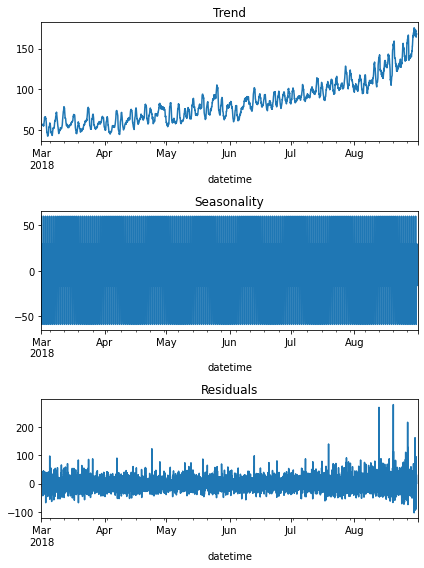

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


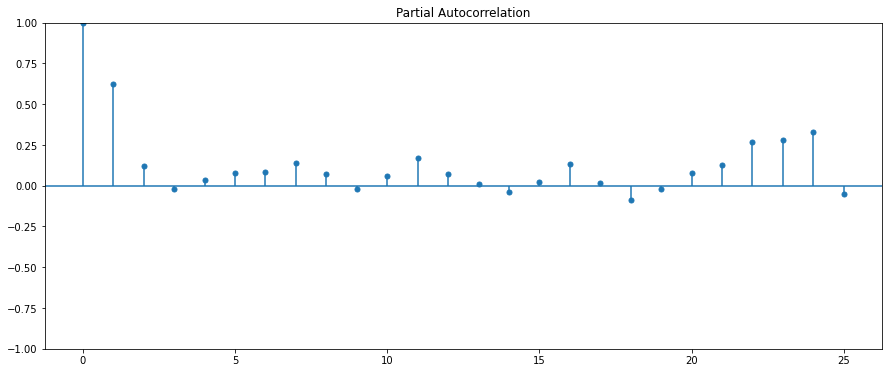

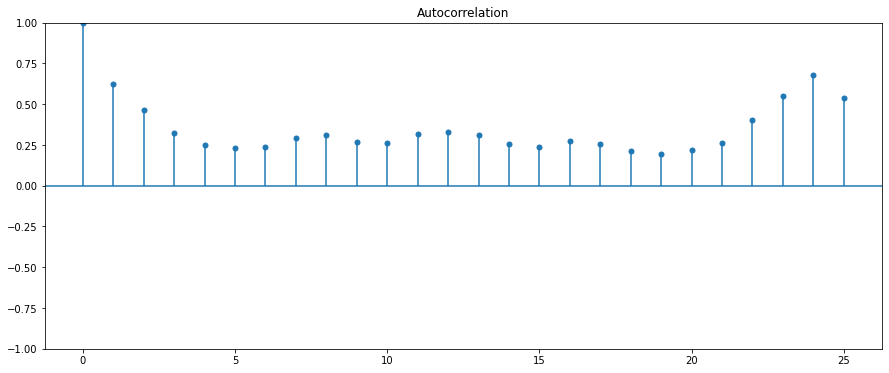

In [14]:
decompose(data['num_orders'])

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(data, 2, 24)

### Вывод

* Мы имеем стационарный ряд, это подтвердил `тест Дики-Фуллера`, но средние значения сильно отличаются.

* Распределение выборки нормально, это подтвердил `тест Харке-Бера`

* были созданы экзогенные признаки для улучшения модели машинного обучения.

* Временной ряд возможно спрогнозировать.

## Обучение

In [17]:
# словарь для результатов обучения
results_data = {'Дерево решений':[], 'Случайный лес':[], 'Линейная регрессия':[], 'Catboost':[], 'LightGBM':[]}

In [18]:
def grid_params(model, params, scoring, features, target):
    '''    
    Input: --> learning algoritm, model parametrs --> dict, scoring method --> str, pd.DataFrame, pd.Series
    Output --> learning algoritm, model_grid.best_params_ --> dict, model_grid.best_score_
    Process: 1. Задаём параметры GridSearchCV
             2. Обучаем модель
             3. Сохраняем лучшие параметры и лучший показатель метрики
    '''        
    
    tscv = TimeSeriesSplit(n_splits=8)
    
    model_grid = GridSearchCV(model, params,
                              n_jobs=-1, cv=tscv, scoring=scoring)
    model_grid.fit(features, target)
    best_params = model_grid.best_params_
    best_score = model_grid.best_score_
    
    display(model_grid)
    display(best_params)
    display(HTML(f'<font color="red"> Лучший результат RMSE:{best_score}</font>'))
    return model_grid, best_params, best_score

In [19]:
# разбиение на выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
train_X = train.drop(columns=['num_orders'])
train_y = train['num_orders']

test_X = test.drop(columns=['num_orders'])
test_y = test['num_orders']

### Проверка модели на адекватность

Для начала проверим модель на константных данных, чтобы убедиться в их адекватности.

In [21]:
print("Средний объём заказов в час:", train['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()
print("MAE с константной моделью 1 типа:", mean_absolute_error(test, pred_median))

pred_previous = test.shift(1 , axis=0, fill_value=train.iloc[-1]['num_orders'])
print("MAE с константной моделью 2 типа:", mean_absolute_error(test, pred_previous))

Средний объём заказов в час: 78.42101265822785
MAE с константной моделью 1 типа: 68.47907239819004
MAE с константной моделью 2 типа: 23.154867395676217


Теперь у нас есть ориентир. Константная модель второго типа ошибается гораздо меньше

### Дерево решений

In [22]:
tree_model = DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range(3, 8, 1)}

In [23]:
start = timer()
model_best_tree, best_params_tree , best_score_tree = grid_params(tree_model, tree_params, 'neg_root_mean_squared_error', train_X, train_y)
end = timer()

tree_timetrain = round((end - start), 2)
print(tree_timetrain)

results_data['Дерево решений'].append(best_score_tree)
results_data['Дерево решений'].append(tree_timetrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(3, 8)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 7}

0.26


### Случайный лес

In [24]:
forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'max_depth': range(1,5,1),
                'n_estimators': range(100,150,10)}

In [25]:
start = timer()
model_best_forest, best_params_forest , best_score_forest = grid_params(forest_model, forest_params, 'neg_root_mean_squared_error', train_X, train_y)
end = timer()

forest_timetrain = round((end - start), 2)
print(forest_timetrain)

results_data['Случайный лес'].append(best_score_forest)
results_data['Случайный лес'].append(forest_timetrain)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'n_estimators': range(100, 150, 10)},
             scoring='neg_root_mean_squared_error')

{'max_depth': 4, 'n_estimators': 140}

34.06


### Линейная регрессия

In [42]:
tscv_linreg = TimeSeriesSplit(n_splits=3)

In [43]:
start = timer()
cv_sc_linReg = cross_val_score(LinearRegression(),
                                        train_X,
                                        train_y,
                                        cv=tscv_linreg, scoring='neg_root_mean_squared_error').min()
end = timer()
linreg_timetrain = round((end - start), 2)
display(HTML(f'<font color="red"> Лучший результат RMSE:{cv_sc_linReg}</font>'))

results_data['Линейная регрессия'].append(cv_sc_linReg)
results_data['Линейная регрессия'].append(linreg_timetrain)

### Catboost

In [32]:
cat_model = CatBoostRegressor()
cat_params = {'depth': [4], 
              'loss_function': ["RMSE"], 
              'iterations': [500],
              'learning_rate': np.arange(0.021,0.025,0.001),
               'verbose': [1],
               'random_state': [12345]}

In [33]:
start = timer()
model_best_cat, best_params_cat , best_score_cat = grid_params(cat_model, cat_params, 'neg_root_mean_squared_error', train_X, train_y)
end = timer()

cat_timetrain = round((end - start), 2)
print(cat_timetrain)

results_data['Catboost'].append(best_score_cat)
results_data['Catboost'].append(cat_timetrain)

0:	learn: 28.9014506	total: 463us	remaining: 231ms
1:	learn: 28.6256633	total: 735us	remaining: 183ms
2:	learn: 28.3273110	total: 1.1ms	remaining: 183ms
3:	learn: 28.0712383	total: 1.43ms	remaining: 177ms
4:	learn: 27.9081210	total: 1.68ms	remaining: 166ms
5:	learn: 27.6278162	total: 1.92ms	remaining: 158ms
6:	learn: 27.4828200	total: 2.17ms	remaining: 153ms
7:	learn: 27.2280308	total: 2.43ms	remaining: 150ms
8:	learn: 26.9783699	total: 2.7ms	remaining: 148ms
9:	learn: 26.7554674	total: 2.96ms	remaining: 145ms
10:	learn: 26.6025709	total: 3.21ms	remaining: 143ms
11:	learn: 26.3563062	total: 3.44ms	remaining: 140ms
12:	learn: 26.1243664	total: 3.69ms	remaining: 138ms
13:	learn: 25.9267951	total: 3.93ms	remaining: 137ms
14:	learn: 25.7171602	total: 4.2ms	remaining: 136ms
15:	learn: 25.5697199	total: 4.43ms	remaining: 134ms
16:	learn: 25.4483932	total: 4.69ms	remaining: 133ms
17:	learn: 25.2279159	total: 4.92ms	remaining: 132ms
18:	learn: 25.0303599	total: 5.15ms	remaining: 130ms
19:	lear

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd10c2fdfd0>,
             n_jobs=-1,
             param_grid={'depth': [4], 'iterations': [500],
                         'learning_rate': array([0.021, 0.022, 0.023, 0.024]),
                         'loss_function': ['RMSE'], 'random_state': [12345],
                         'verbose': [1]},
             scoring='neg_root_mean_squared_error')

{'depth': 4,
 'iterations': 500,
 'learning_rate': 0.024000000000000004,
 'loss_function': 'RMSE',
 'random_state': 12345,
 'verbose': 1}

21.51


### LightGBM

In [30]:
lgbm_model = LGBMRegressor()
lgbm_params = {'max_depth': range(1,5,1),
                   'objective': ['regression'],
                   "metric": ['rmse'],
                   'n_estimators': range(550, 750, 50),
                   'learning_rate':np.arange(0.021,0.024,0.001),
                    "verbosity": [1],
                   'random_state': [12345],
                   "boosting_type": ['gbdt']}

In [ ]:
start = timer()
model_best_lgbm, best_params_lgbm , best_score_lgbm = grid_params(lgbm_model , lgbm_params, 'neg_root_mean_squared_error', train_X, train_y)
end = timer()

lgbm_timetrain = round((end - start), 2)
print(lgbm_timetrain)

results_data['LightGBM'].append(best_score_lgbm)
results_data['LightGBM'].append(lgbm_timetrain)

In [44]:
train_df = pd.DataFrame(data=results_data, index=['RMSE', 'Time_learning(sec)'])
train_df

ValueError: could not broadcast input array from shape (12,) into shape (2,)

Лучший результат на обучении показала себя линейная регрессия, но протестируем все  модели.

## Тестирование

In [46]:
test_data = {'Дерево решений':[], 'Случайный лес':[], 'Линейная регрессия':[], 'Catboost':[], 'LightGBM':[]}

In [47]:
def test_pred_plot(test_y, predictions, model_name):
    
    plt.figure(figsize=(15, 10))
    plt.plot(test_y.values, label="test_y")
    plt.plot(predictions, "r", label="prediction")
    plt.legend()
    plt.title(f"RMSE {model_name}: {test_data[model_name][0]}")
    plt.grid(True);

RMSE:58.13279535646877


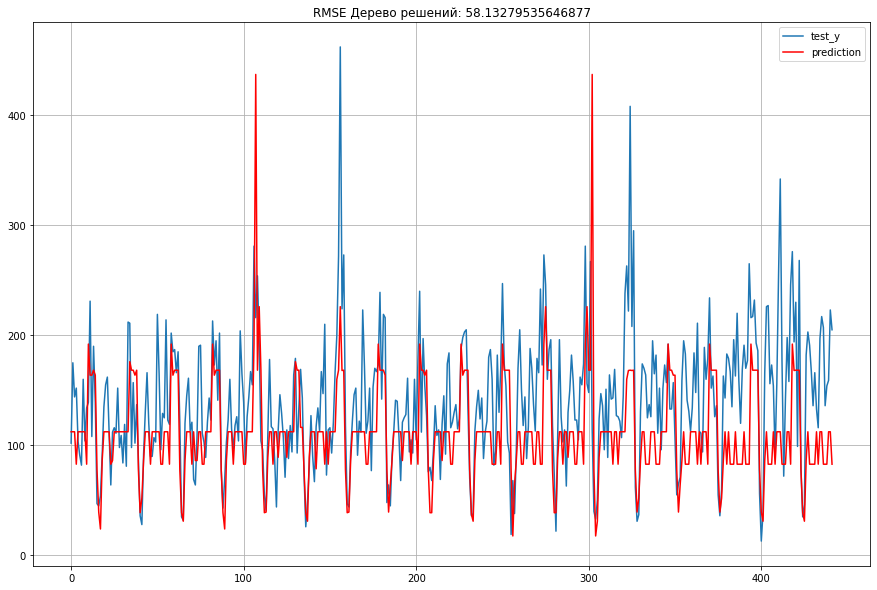

In [48]:
predict_tree = model_best_tree.predict(test_X)
result_rmse_tree = mean_squared_error(test_y, predict_tree)**0.5
print(f'RMSE:{result_rmse_tree}')
test_data['Дерево решений'].append(result_rmse_tree)

test_pred_plot(test_y, predict_tree, 'Дерево решений')

RMSE:56.881484240318


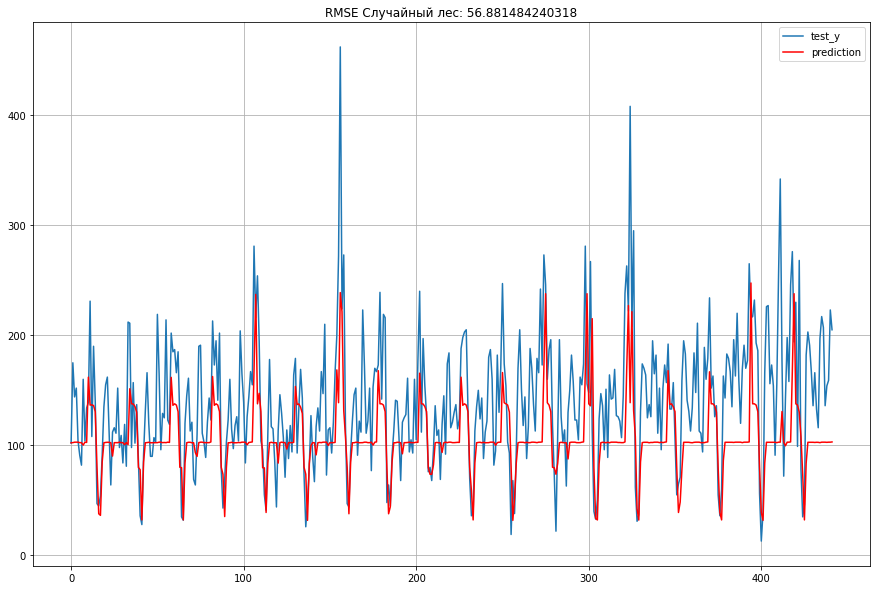

In [49]:
predict_forest = model_best_forest.predict(test_X)
result_rmse_forest = mean_squared_error(test_y, predict_forest)**0.5
print(f'RMSE:{result_rmse_forest}')
test_data['Случайный лес'].append(result_rmse_forest)

test_pred_plot(test_y, predict_forest, 'Случайный лес')

In [50]:
cv_sc_linReg_test = cross_val_score(LinearRegression(),
                                        test_X,
                                        test_y,
                                        cv=tscv_linreg, scoring='neg_root_mean_squared_error').mean()

print(f'RMSE:{cv_sc_linReg_test}')

test_data['Линейная регрессия'].append(cv_sc_linReg_test)

RMSE:-54.46329309328994


RMSE:48.907920220025055


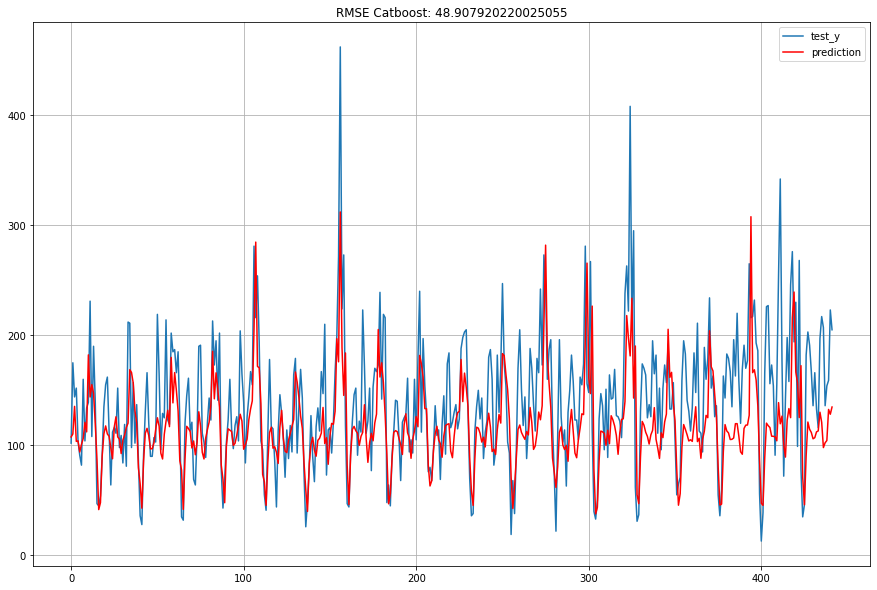

In [51]:
predict_cat = model_best_cat.predict(test_X)
result_rmse_cat = mean_squared_error(test_y, predict_cat)**0.5
print(f'RMSE:{result_rmse_cat}')

test_data['Catboost'].append(result_rmse_cat)

test_pred_plot(test_y, predict_cat, 'Catboost')

In [ ]:
predict_lgbm = model_best_lgbm.predict(test_X)
result_rmse_lgbm = mean_squared_error(test_y, predict_lgbm)**0.5
print(f'RMSE:{result_rmse_lgbm}')

test_data['LightGBM'].append(result_rmse_lgbm)

test_pred_plot(test_y, predict_lgbm, 'LightGBM')

In [ ]:
pd.DataFrame(data=test_data, index=['RMSE'])

### Вывод

* Данные были просемплированы.

* Был проведён анализ тренда, сезонности и стационарнность времянного ряда.

* Добавлены новые признаки для обучения моделей машинного обучения.

* Исследованы результаты обучения и предсказаний: Лучший результат на тестах, а так же удовлетворяющие требованию заказчика выступили модели `Catboost` и `LightGBM`